Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Day 1:  Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [✓] Choose your target. Which column in your tabular dataset will you predict?
        A: target = 'is_churn'

- [✓] Is your problem regression or classification?
        A:  Binary classification + also focus on predicted probabilities (predict_proba, non-binary)

- [✓] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?


            A:  Highly imbalanced: 94% did not churn ('is_churn' == 0), while 6% did churn in Feb. 2017.  This makes sense considering 6% of your total subscribers churning every month is not low -- if it was e.g., 50%, the business would collapse in 1-2 months.  Will take a look at class_balance params, but given there are still many more 'is_churn'=1 observations than I need, I most likely will not try to change this balance when sampling.  Instead, I will focus on different metrics -- recall ("hit rate"), false negative rate (FNR or "miss rate") and log loss -- when setting up my predictive model(s).
    
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [✓] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
        

            A:  A time-based split.  I am using the separate March 2017 datasets as the test sets, and not touching them during the predictive modeling process, in order to avoid any leakage.
        

- [✓] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?

            A:  94% of the observations in the training set are in my majority class and did not churn in Feb. 2017 ('is_churn' == 0), while 6% did churn in Feb. 2017.  As such, accuracy is unlikely to be useful -- a dummy majority classifier baseline is already 94% accurate, BUT has 0.0 recall.  With this problem, our priority is to predict what probability each user has of churning "next" month and identify those users we predict will churn, so our customer retention and/or sales team(s) can try to better engage those users.  So it is most important to successfully predict all/most of the users who will churn (high recall), and false positives are actually not too problematic (we can accept lower precision if doing so will increase our recall).  As such, the metrics I will use for evaluating my models are:
        (1) recall ("hit rate"), 
        (2) false negative rate (FNR or "miss rate"), and 
        (3) log loss -- when setting up my predictive model(s).


- [✓] Begin to clean and explore your data.


- [✓] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

# **Setup + Import Dataset:**

In [1]:
# Import libraries used:
import pandas as pd
import numpy as np

import re
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

In [2]:
!pwd

/Users/huskeycl/LSDS_Unit_2/U2-S4_build_project_2_kkbox_churn


In [3]:
!ls

Project - U2-S4 - KKBox Subscriber Churn.ipynb
Scratch Notebook -- To Remove.ipynb
WSDMChurnLabeller.scala
kaggle_kkbox_source_files.zip
members_v3.csv
members_v3.csv.7z
sample_submission_v2.csv
sample_submission_v2.csv.7z
sample_submission_zero.csv
sample_submission_zero.csv.7z
train.csv
train.csv.7z
train_v2.csv
train_v2.csv.7z
transactions.csv
transactions.csv.7z
transactions_v2.csv
transactions_v2.csv.7z
user_logs.csv
user_logs.csv.7z
user_logs_v2.csv
user_logs_v2.csv.7z


In [4]:
# !unzip kaggle_kkbox_source_files.zip

In [5]:
# [?? To do:  Unzip .7z files to get .csv files ??]

In [6]:
# Make working_data (training + val) and test dataframes:
working_data = pd.read_csv('train.csv')
test = pd.read_csv('train_v2.csv')

# Make other dataframes (to merge with train and test):
members_all = pd.read_csv('members_v3.csv')
transactions_all = pd.read_csv('transactions.csv')
transactions_all_test = pd.read_csv('transactions_v2.csv')

In [7]:
# WARNING!:  These are 30.5 GB and 1.4 GB files -- run this cell only when 
# necessary!
user_logs_all = pd.read_csv('user_logs.csv')
user_logs_all_test = pd.read_csv('user_logs_v2.csv')

In [8]:
# Split working_data into train and val sets:
train_all, val_all = train_test_split(working_data, 
                                      train_size=0.75, 
                                      shuffle=True, 
                                      stratify=working_data['is_churn'], 
                                      random_state=42
                                     )

In [73]:
train_all.shape, val_all.shape, test.shape, working_data.shape

((744698, 2), (248233, 2), (970960, 2), (992931, 2))

In [10]:
members_all.shape, transactions_all.shape, transactions_all_test.shape, user_logs_all.shape, user_logs_all_test.shape

((6769473, 6), (21547746, 9), (1431009, 9), (392106543, 9), (18396362, 9))

In [11]:
train_all.head()

,msno,is_churn
559044,gI4blF6CkP3onUuzIhfIdRKJnrOqWBUA0u5o6tMxReY=,0
55370,7qR+fdnLrIIHOBrC/8suq7/WtE0eUKfuecSnMqZAcss=,1
468415,UiPP09716uGg+38pSk7IpPwj28uXvMMnYXfJEDjSJRg=,0
626556,umZYC0ziaim27jnjvx0f2+ip0ZsBUStskgw4k1K5630=,0
423546,oXHPj/8Ri4D+nVo1/Okvy4H0xUZRpsH7HmpuA0giUKw=,0


In [12]:
members_all.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [14]:
transactions_all.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [16]:
user_logs_all.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150513,0,0,0,0,1,1,280.335
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150709,9,1,0,0,7,11,1658.948
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150105,3,3,0,0,68,36,17364.956
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150306,1,0,1,1,97,27,24667.317
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150501,3,0,0,0,38,38,9649.029


In [17]:
working_data['msno'].nunique()

992931

In [18]:
members_all[members_all['msno'].isin(working_data['msno'])].shape[0]

877161

In [19]:
members_all[members_all['msno'].isin(working_data['msno'])]['msno'].nunique()

877161

In [20]:
transactions_all[transactions_all['msno'].isin(working_data['msno'])].shape[0]

15883148

In [21]:
transactions_all[transactions_all['msno'].isin(working_data['msno'])]['msno'].nunique()

992931

In [22]:
user_logs_all[user_logs_all['msno'].isin(working_data['msno'])].shape[0]

245546797

In [23]:
user_logs_all[user_logs_all['msno'].isin(working_data['msno'])]['msno'].nunique()

869926

# !!! DON'T RERUN ABOVE THIS !!!  
(takes 10 years to run)

### Subsets:  Take random sample to get subset of data (otherwise too large a dataset to work with efficiently):

In [172]:
# Subsets:  Take IID random samples of train and val that we will work with.  train_all and val_all are too large.
train = train_all.sample(frac=0.005, replace=True, random_state=42)  # [?? To do: change to much larger subset (e.g., 100k) and remove all random_states at end ??]
train.reset_index(inplace=True, drop=True)

val = val_all.sample(frac=0.005, replace=True, random_state=42)  # [?? To do: remove this and validate with all of val_all? ??]
val.reset_index(inplace=True, drop=True)

# [?? To do: Remove below? -- this sets val index as continuing from train index, instead of new from 0 ??]
# val_index = np.array(range(len(train['msno']), len(train['msno']) + len(val['msno'])))
# val.set_index(keys=val_index, inplace=True)

In [173]:
# Make a list of all msno IDs in the train and val subsets + in test, for our data_prep function (otherwise data_prep produces all NaNs, because the msno ID doesn't match anything):
all_subsets_msnos = list(train['msno']) + list(val['msno'])
# [?? To do: Add test set msnos to above list too, so data_prep doesn't turn all values in test to NaNs!! --> add test set to data_prep below ??]

In [174]:
# Take subsets of members, transactions, user_logs for only those users included in the above subsets 
# (otherwise compute time is unfeasibly long, e.g., for all 24.6 mn rows in user_logs):
members = members_all[members_all['msno'].isin(all_subsets_msnos)]
transactions = transactions_all[transactions_all['msno'].isin(all_subsets_msnos)]
user_logs = user_logs_all[user_logs_all['msno'].isin(all_subsets_msnos)]

In [175]:
train.head()

,msno,is_churn
0,GjdWJ5iCawbLfsPpRI5xkIwwpd8oCAGiB5dLCBFIEog=,0
1,7/7ebApkG0bEw7h1G2tL8ETyhAbqqTRN/7ZXHliRY90=,0
2,gQTPK2W2+Fbwhx7l04kg/yMyOL68zbXibrqt/SMtjc8=,0
3,o+ocfyzqpxd79+Lt1W305vQ90gnqOpToLRQdxnLeUDE=,0
4,Uxut7Crxl0njiRxUo9EVcM5+wp9nLlVMMROQakXjmVI=,0


In [176]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
1577,DmNMeWtvaqaYKoQoO4VtT7bLsLVzdvpvPX4pUnZPz0o=,5,35,female,9,20070402
2215,t5yN5FwhvS85HXdLxWT4LQnBEuWLGrgULdkw7GlHLkc=,5,30,male,9,20090202
8487,mRbeIVIw7aAZUZB1iD8g4df0gM+sSFxPB2hYKlM0QpM=,5,33,female,7,20120227
8591,dNX0aqhfL+XOvzVfhZlvbVEmvq4qHsS0zq7k3PB+RHA=,1,0,NaN,7,20120404
8881,oidOZXGMeVyZo0g4jlABf0Tqwd9NDD0enjxK/wM910A=,22,52,male,3,20131123


In [177]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
680,I9tTfNvK6lyq27qAPuKou1zlA+IJUbC+LfgbOY34hZ4=,41,30,129,129,1,20160919,20161118,0
789,hjt3RjBq/exmoe7thjBOd9mfZ8PBpZrJuPK6VFIo3qk=,41,30,99,99,1,20160106,20160206,0
899,lmPhHrk5Eb88tIq2mRU3wrlsAj7g/sQK9wpRIb/0F6I=,41,30,99,99,1,20160402,20160502,0
1656,mhuz4c3/RwwaVh8pu80ekVFB721vdKxcd/sSGG3EK9M=,40,30,149,149,1,20160312,20160412,0
1737,1JgKynnZ1SjO19FdLUrNffjPxcbRX+/mJLgQ1GGR8Z8=,41,30,99,99,1,20160611,20160711,0


In [178]:
user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1493,KAtqQnhOokDvGkV866gfxl0LhH7XLVgZgCYIzDurfUA=,20150912,2,3,0,0,27,30,7448.078
1494,KAtqQnhOokDvGkV866gfxl0LhH7XLVgZgCYIzDurfUA=,20160117,0,0,0,0,30,30,7440.876
1495,KAtqQnhOokDvGkV866gfxl0LhH7XLVgZgCYIzDurfUA=,20160315,12,1,2,3,14,28,3980.775
1496,KAtqQnhOokDvGkV866gfxl0LhH7XLVgZgCYIzDurfUA=,20160506,36,4,2,4,44,85,12237.086
1497,KAtqQnhOokDvGkV866gfxl0LhH7XLVgZgCYIzDurfUA=,20160713,26,3,2,2,28,57,8308.725


# **Data Prep. & Feature Engineering:**

In [179]:
# Set the correct "today" variable for the dataset = the last day of the train/val data + 1 day:
last_day_of_train = dt.datetime(2017, 3, 1)

In [180]:
def data_prep(dataframe, members, transactions, user_logs):
    # [?? To do: Best to make copies or no ??]
    df = dataframe.copy()
    members = members.copy()
    transactions = transactions.copy()
    user_logs = user_logs.copy()    
    
    # Members:
    members['registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
    members.rename(columns={'bd': 'age'}, inplace=True)
    
    # Transactions:
    # [?? To do... ??]
    transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')
    transactions['membership_expire_date'] = pd.to_datetime(transactions['membership_expire_date'], format='%Y%m%d')
    transactions['actual_amount_paid_per_30_days'] = transactions['actual_amount_paid'] / (transactions['payment_plan_days'] / 30)
    transactions['actual_amount_paid_per_30_days'].replace({np.inf: np.NaN}, inplace=True)
    
    # User Logs (listening data):
    user_logs['date'] = pd.to_datetime(user_logs['date'], format='%Y%m%d')
    
    # Merge key features into main dataframe:
    df = pd.merge(df, members, how='left', on='msno')
    
    # Main dataframe:  OneHot encoding for 0/1 binary features with NaNs:
    columns_for_onehot = ['gender']
    encoder_onehot = ce.OneHotEncoder(use_cat_names=True)
    encoded_columns_onehot = encoder_onehot.fit_transform(df[columns_for_onehot])
    
    encoded_columns_onehot['msno'] = df['msno']                       # Add back msno numbers to merge
    df = pd.merge(df, encoded_columns_onehot, how='left', on='msno')
    
    # New features:
    # [?? To do: implement these + other key features to improve model inputs ??]
    # current price
    # total time as member (including on and off...) -- is this actually worth implementing, or already mostly captured by the below total_days_since_joined ??
    # has canceled/churned before + how many times
    # autorenew streak (months)
    # uninterrupted time as member
    # listening time in seconds
    # listening time last month vs. before
    # bad recommendations?? (# of songs played for <25% of song length) -- but how many of these are due to recommended song vs. chosen song?
    df['total_days_since_joined'] = (last_day_of_train - df['registration_init_time']).dt.days
    
    # [????????? The below for loop is INSANELY computationally inefficient -- how to do this in a feasible way? ?????????????????????????????]

    for row in df.index:
        if df.loc[row, 'msno'] in set(transactions['msno']):
            df.loc[row, 'cost_per_month'] = transactions[transactions['msno'] == df.loc[row, 'msno']].sort_values(by='transaction_date', ascending=True).iloc[-1]['actual_amount_paid_per_30_days']
        else:
            df.loc[row, 'cost_per_month'] = np.NaN
    
    # [??????????????????????????????????????]
    
    return df, members, transactions, user_logs

In [181]:
train, members, transactions, user_logs = data_prep(train, members, transactions, user_logs)
val, members, transactions, user_logs = data_prep(val, members, transactions, user_logs)
# [?? To do:  Rewrite the data_prep functions more efficiently --> run on larger % of train, val and all of test (commented out below) ??]
# test, members, transactions_all_test, user_logs_all_test = data_prep(test, members, 
#                                                                      transactions_all_test, user_logs_all_test)

In [182]:
train

,msno,is_churn,city,age,gender,registered_via,registration_init_time,gender_nan,gender_female,gender_male,total_days_since_joined,cost_per_month
0,GjdWJ5iCawbLfsPpRI5xkIwwpd8oCAGiB5dLCBFIEog=,0,1.0,0.0,NaN,7.0,2016-06-04,1,0,0,270.0,99.0
1,7/7ebApkG0bEw7h1G2tL8ETyhAbqqTRN/7ZXHliRY90=,0,22.0,25.0,female,3.0,2013-02-27,0,1,0,1463.0,149.0
2,gQTPK2W2+Fbwhx7l04kg/yMyOL68zbXibrqt/SMtjc8=,0,22.0,31.0,male,9.0,2006-10-22,0,0,1,3783.0,149.0
3,o+ocfyzqpxd79+Lt1W305vQ90gnqOpToLRQdxnLeUDE=,0,22.0,25.0,female,9.0,2015-03-27,0,1,0,705.0,149.0
4,Uxut7Crxl0njiRxUo9EVcM5+wp9nLlVMMROQakXjmVI=,0,1.0,0.0,NaN,7.0,2014-08-15,1,0,0,929.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3738,e0/hU0iEpIqIhtaugDesdWheMswI+Xpxe8QfVpL9OiI=,0,1.0,0.0,NaN,7.0,2015-08-25,1,0,0,554.0,99.0
3739,Xtc95UDY2Md8g750lX12dS8GoeA3L//1tbVTCNXjDlM=,0,13.0,51.0,male,7.0,2016-08-07,0,0,1,206.0,99.0
3740,4z3wCmZaKgID8+nJ9tLRgsxhhejeYFeMol02fyaBkhQ=,0,6.0,18.0,female,3.0,2015-08-25,0,1,0,554.0,149.0
3741,thV2tZgtt1Y6KlR9vAkiP9xSdCTmxWEz4LGMM/wVevI=,0,1.0,0.0,NaN,7.0,2013-11-19,1,0,0,1198.0,99.0


In [183]:
val

,msno,is_churn,city,age,gender,registered_via,registration_init_time,gender_nan,gender_male,gender_female,total_days_since_joined,cost_per_month
0,Bu3vaBx1CkanJ9UmbJk70x3qIc1WBkVeOkGGwB+FAVc=,0,1.0,0.0,NaN,4.0,2016-04-29,1,0,0,306.0,149.0
1,Zx6c9VSBnj0O8L4SuNXpu/yV5QYo7XSvv1VjSImaF7k=,0,NaN,NaN,NaN,NaN,NaT,1,0,0,NaN,99.0
2,j9T1MdUTuRCURN/TPotX1b2Jhd6uGChCF63RbkVToZI=,0,4.0,30.0,male,9.0,2011-03-07,0,1,0,2186.0,149.0
3,KAmIIc7EsTcjkqc16YmKJsdfAoUBN2NzJLSiej5TFt4=,1,1.0,0.0,NaN,4.0,2016-04-30,1,0,0,305.0,149.0
4,gp5uBnYOMtyCH0I0OWD+TdSp3cSeD13gJHotGtf1wiY=,0,1.0,0.0,NaN,7.0,2013-02-03,1,0,0,1487.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1240,fLSjcK5W4NTjhbKlORmGMfrknAO1xwjnQ+GeGdANBhU=,0,13.0,0.0,NaN,9.0,2015-09-11,1,0,0,537.0,180.0
1241,WCWB8d3EMVxH6JUi610ATZurrgs/9ghHqIdEYgrL26s=,0,1.0,0.0,NaN,7.0,2016-12-31,1,0,0,60.0,99.0
1242,Q52NNs70jriB0Pm1Kh8i942ifXov8aYS48klzMKo5hU=,0,4.0,22.0,female,9.0,2007-10-06,0,0,1,3434.0,149.0
1243,hAJTkAZ6qZIFQsulsXWLYYxPQWdhhTarK60Q7niLL0g=,0,1.0,0.0,NaN,7.0,2016-12-04,1,0,0,87.0,99.0


In [184]:
# Take a look at our training data with Pandas profiling:
import pandas_profiling

train_profile_report = train.profile_report(
    check_correlation_pearson=False, 
    correlations={
        'pearson': False, 
        'spearman': False, 
        'kendall': False, 
        'phi_k': False, 
        'cramers': False, 
        'recoded':False
    }, 
    plot={'histogram': {'bayesian_blocks_bins': False}}
)
train_profile_report

### TEST:  1 single user for reference [?? To do: remove ??]

In [185]:
z_test234 = train.sample(n=1, replace=False, random_state=42)
z_test234 = list(z_test234['msno'])

In [186]:
z_test234

['u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=']

In [187]:
train[train['msno'].isin(z_test234)]

,msno,is_churn,city,age,gender,registered_via,registration_init_time,gender_nan,gender_female,gender_male,total_days_since_joined,cost_per_month
3398,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,0,15.0,23.0,female,3.0,2014-11-20,0,1,0,832.0,149.0


In [188]:
members[members['msno'].isin(z_test234)]

,msno,city,age,gender,registered_via,registration_init_time
1293183,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,15,23,female,3,2014-11-20


In [189]:
transactions[transactions['msno'].isin(z_test234)]

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,actual_amount_paid_per_30_days
2927275,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,35,7,0,0,0,2016-07-26,2016-08-31,0,0.0
2986825,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,38,30,149,149,0,2016-05-22,2016-06-21,0,149.0
3183456,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,38,30,149,149,0,2016-06-23,2016-07-23,0,149.0
4251502,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,38,30,149,149,0,2016-01-17,2016-02-16,0,149.0
4870686,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,38,30,149,149,0,2017-01-26,2017-02-25,0,149.0
6711645,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,38,30,149,149,0,2016-10-06,2016-11-05,0,149.0
9622233,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,38,30,149,149,0,2016-12-24,2017-01-23,0,149.0
9968317,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,38,30,149,149,0,2016-04-21,2016-05-21,0,149.0
11115713,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,38,30,149,149,0,2016-11-11,2016-12-11,0,149.0
14914769,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,38,30,149,149,0,2016-03-20,2016-04-19,0,149.0


In [190]:
user_logs[user_logs['msno'].isin(z_test234)]

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
3324056,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,2015-02-02,7,2,2,2,89,89,23821.057
3324057,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,2015-05-12,0,0,0,0,18,18,4490.399
3324058,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,2015-07-07,0,2,0,0,41,43,9857.059
3324059,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,2015-08-31,1,0,0,0,9,10,2302.854
3324060,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,2015-10-24,2,0,0,1,46,46,12022.089
...,...,...,...,...,...,...,...,...,...
389584130,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,2016-06-24,11,2,2,0,45,58,11936.185
389584131,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,2016-08-21,1,0,0,0,22,21,5404.980
389584132,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,2016-10-12,3,1,0,0,19,23,4760.944
389584133,u2b0f+6xcMmtXEWh6Yi8/arPPQOtPIxHXylJA47pjMk=,2016-12-06,1,0,0,0,19,20,4743.347


# **Feature Selection:**

In [191]:
train

,msno,is_churn,city,age,gender,registered_via,registration_init_time,gender_nan,gender_female,gender_male,total_days_since_joined,cost_per_month
0,GjdWJ5iCawbLfsPpRI5xkIwwpd8oCAGiB5dLCBFIEog=,0,1.0,0.0,NaN,7.0,2016-06-04,1,0,0,270.0,99.0
1,7/7ebApkG0bEw7h1G2tL8ETyhAbqqTRN/7ZXHliRY90=,0,22.0,25.0,female,3.0,2013-02-27,0,1,0,1463.0,149.0
2,gQTPK2W2+Fbwhx7l04kg/yMyOL68zbXibrqt/SMtjc8=,0,22.0,31.0,male,9.0,2006-10-22,0,0,1,3783.0,149.0
3,o+ocfyzqpxd79+Lt1W305vQ90gnqOpToLRQdxnLeUDE=,0,22.0,25.0,female,9.0,2015-03-27,0,1,0,705.0,149.0
4,Uxut7Crxl0njiRxUo9EVcM5+wp9nLlVMMROQakXjmVI=,0,1.0,0.0,NaN,7.0,2014-08-15,1,0,0,929.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3738,e0/hU0iEpIqIhtaugDesdWheMswI+Xpxe8QfVpL9OiI=,0,1.0,0.0,NaN,7.0,2015-08-25,1,0,0,554.0,99.0
3739,Xtc95UDY2Md8g750lX12dS8GoeA3L//1tbVTCNXjDlM=,0,13.0,51.0,male,7.0,2016-08-07,0,0,1,206.0,99.0
3740,4z3wCmZaKgID8+nJ9tLRgsxhhejeYFeMol02fyaBkhQ=,0,6.0,18.0,female,3.0,2015-08-25,0,1,0,554.0,149.0
3741,thV2tZgtt1Y6KlR9vAkiP9xSdCTmxWEz4LGMM/wVevI=,0,1.0,0.0,NaN,7.0,2013-11-19,1,0,0,1198.0,99.0


In [192]:
val

,msno,is_churn,city,age,gender,registered_via,registration_init_time,gender_nan,gender_male,gender_female,total_days_since_joined,cost_per_month
0,Bu3vaBx1CkanJ9UmbJk70x3qIc1WBkVeOkGGwB+FAVc=,0,1.0,0.0,NaN,4.0,2016-04-29,1,0,0,306.0,149.0
1,Zx6c9VSBnj0O8L4SuNXpu/yV5QYo7XSvv1VjSImaF7k=,0,NaN,NaN,NaN,NaN,NaT,1,0,0,NaN,99.0
2,j9T1MdUTuRCURN/TPotX1b2Jhd6uGChCF63RbkVToZI=,0,4.0,30.0,male,9.0,2011-03-07,0,1,0,2186.0,149.0
3,KAmIIc7EsTcjkqc16YmKJsdfAoUBN2NzJLSiej5TFt4=,1,1.0,0.0,NaN,4.0,2016-04-30,1,0,0,305.0,149.0
4,gp5uBnYOMtyCH0I0OWD+TdSp3cSeD13gJHotGtf1wiY=,0,1.0,0.0,NaN,7.0,2013-02-03,1,0,0,1487.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1240,fLSjcK5W4NTjhbKlORmGMfrknAO1xwjnQ+GeGdANBhU=,0,13.0,0.0,NaN,9.0,2015-09-11,1,0,0,537.0,180.0
1241,WCWB8d3EMVxH6JUi610ATZurrgs/9ghHqIdEYgrL26s=,0,1.0,0.0,NaN,7.0,2016-12-31,1,0,0,60.0,99.0
1242,Q52NNs70jriB0Pm1Kh8i942ifXov8aYS48klzMKo5hU=,0,4.0,22.0,female,9.0,2007-10-06,0,0,1,3434.0,149.0
1243,hAJTkAZ6qZIFQsulsXWLYYxPQWdhhTarK60Q7niLL0g=,0,1.0,0.0,NaN,7.0,2016-12-04,1,0,0,87.0,99.0


**Final Features Selected:**

In [194]:
# Define final features and target, based on above findings re feature importances:
target = 'is_churn'

features = set(train.columns)
to_remove = set([
                 # Target variable:
                 target, 
                 
                 # Irrelevant information and/or no variance:
                 # [?? To do ??]
                 'msno', 'registration_init_time', 'gender', 
                 
                 # Redundant (near copies of info in other columns):
                 # [?? To do ??]
                 
                 # Very low permutation importances:
                 # [?? To do ??]
                 ])
features = list(features - to_remove)

# Features matrices and target vectors for train and val sets:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
# X_test = test[features]  # [?? To do: Reinstate test here and everywhere above!! ??]

# # Check to make sure X matrices have the same numbers of columns:
# assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]

In [196]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape
# X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape

((3743, 9), (1245, 9), (3743,), (1245,))

# **Baselines:**

**Baseline 1:  Dummy Model:  Majority Classifier:**

In [197]:
y_train.value_counts(dropna=False, normalize=True)

0    0.933476
1    0.066524
Name: is_churn, dtype: float64

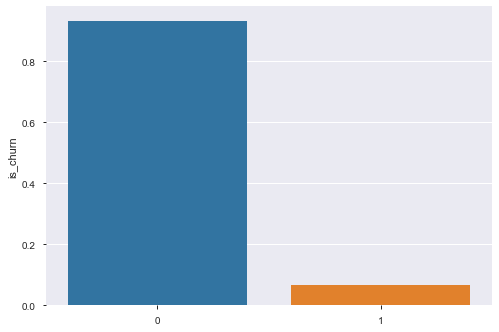

In [198]:
sns.barplot(x=y_train.value_counts(normalize=True).index, 
            y=y_train.value_counts(normalize=True));

In [199]:
majority_class = y_train.mode()[0]

In [200]:
# Get relevant score for our Baseline 1: Majority Classifier dummy model:
y_true_val = y_val
y_pred_b1_val = [majority_class] * len(y_val)

# Get confusion matrix:
cm_b1_val = pd.DataFrame(confusion_matrix(y_true_val, y_pred_b1_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b1_val.loc['actual_1', 'pred_1']
FN = cm_b1_val.loc['actual_1', 'pred_0']
FP = cm_b1_val.loc['actual_0', 'pred_1']
TN = cm_b1_val.loc['actual_0', 'pred_0']

print('\nBaseline 1:  Majority Classifier Performance:\n')
print(f'Accuracy: {accuracy_score(y_true_val, y_pred_b1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_val, y_pred_b1_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')
y_pred_b1_val_proba = np.full(shape=(len(y_val), 2), fill_value=[1.0, 0.0])
print(f'Log loss (negative): {log_loss(y_true_val, y_pred_b1_val_proba, eps=10**-15):.3f}')
cm_b1_val


Baseline 1:  Majority Classifier Performance:

Accuracy: 0.943
Recall : 0.000
False Negative Rate ("Miss Rate"): 1.000
Log loss (negative): 1.970


,pred_0,pred_1
actual_0,1174,0
actual_1,71,0


In [201]:
# Confusion matrix, normalized:
cm_b1_val / cm_b1_val.sum().sum()

,pred_0,pred_1
actual_0,0.942972,0.0
actual_1,0.057028,0.0


In [202]:
# # Alternate version using sklearn's DummyClassifier class:

# # Get relevant score for our Baseline 1: Majority Classifier dummy model:

# # Import estimator class:
# from sklearn.dummy import DummyClassifier

# # Initialize estimator class:
# b1_dummyclassifier =  DummyClassifier(strategy='most_frequent', random_state=42)

# # Preprocessing:  No need to encode, impute or scale here.

# # Fit model to training data:
# b1_dummyclassifier.fit(X_train, y_train)

# # Apply to val set and get performance metrics:
# y_true_val = y_val
# y_pred_b1_val_dc = b1_dummyclassifier.predict(X_val)


# # Get confusion matrix:
# cm_b1_val_dc = pd.DataFrame(confusion_matrix(y_true_val, y_pred_b1_val_dc), 
#                         index=['actual_0', 'actual_1'], 
#                         columns=['pred_0', 'pred_1'])
# TP = cm_b1_val.loc['actual_1', 'pred_1']
# FN = cm_b1_val.loc['actual_1', 'pred_0']
# FP = cm_b1_val.loc['actual_0', 'pred_1']
# TN = cm_b1_val.loc['actual_0', 'pred_0']

# print('Baseline 1:  Majority Classifier Performance:')
# print(f'Accuracy: {accuracy_score(y_true_val, y_pred_b1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
# print(f"Recall 2: {recall_score(y_true_val, y_pred_b1_val, average='binary'):.3f}")  # TP / (TP + FN)
# print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')
# # [?? To do:  Log loss ??]
# print(f'Log loss (negative): {log_loss(y_true_val, b1_dummyclassifier.predict_proba(X_val), eps=10**-15):.3f}')

# **Models/Predictions:**

### Model 2: RandomForest Classifier:

In [295]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, min_samples_leaf=2, n_jobs=-1, random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)

# Apply to train and get score:
y_true_m2_train = y_train
y_pred_m2_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_m2_train = pd.DataFrame(confusion_matrix(y_true_m2_train, y_pred_m2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_train.loc['actual_1', 'pred_1']
FN = cm_m2_train.loc['actual_1', 'pred_0']
FP = cm_m2_train.loc['actual_0', 'pred_1']
TN = cm_m2_train.loc['actual_0', 'pred_0']

print('\nModel #2: RandomForestClassifier Performance:\n')
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_train, y_pred_m2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_train, y_pred_m2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_m2_train, y_pred_m2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m2_train / cm_m2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m2_train / cm_m2_train.sum().sum()


Model #2: RandomForestClassifier Performance:

TRAINING SET:

Accuracy: 0.959
Recall : 0.390
"Miss Rate" (FNR): 0.610
Log loss (negative): 0.093



In [296]:
# Apply to val and get score:
y_true_m2_val = y_val
y_pred_m2_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_m2_val = pd.DataFrame(confusion_matrix(y_true_m2_val, y_pred_m2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_val.loc['actual_1', 'pred_1']
FN = cm_m2_val.loc['actual_1', 'pred_0']
FP = cm_m2_val.loc['actual_0', 'pred_1']
TN = cm_m2_val.loc['actual_0', 'pred_0']

print('\nModel #2: RandomForestClassifier Performance:\n')
print('VALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_val, y_pred_m2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_val, y_pred_m2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_m2_val, y_pred_m2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m2_val / cm_m2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m2_val / cm_m2_val.sum().sum()


Model #2: RandomForestClassifier Performance:

VALIDATION SET:

Accuracy: 0.943
Recall : 0.028
"Miss Rate" (FNR): 0.972
Log loss (negative): 0.232

Confusion matrix, normalized:


,pred_0,pred_1
actual_0,0.941365,0.001606
actual_1,0.055422,0.001606


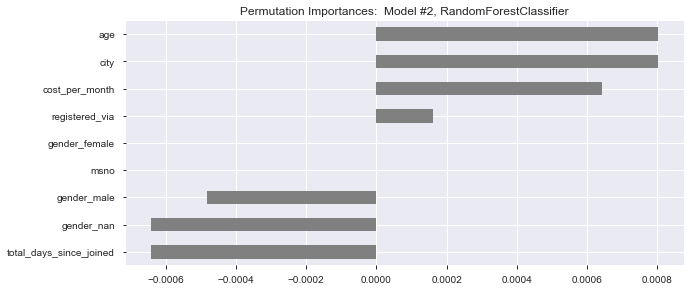

In [298]:
# Permutation importances:

# Separate out the estimator from pipeline, so we can use the eli5 library:

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m2_rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, n_jobs=-1, random_state=42)
m2_rf.fit(X_train_transformed, y_train)

# -----------------------------------------------------------------------------------------------------------

# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_rf = PermutationImportance(
    m2_rf, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter_rf.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_rf = pd.Series(permuter_rf.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_rf.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #2, RandomForestClassifier')
plt.show()

In [299]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_rf, 
    top=None, 
    feature_names=feature_names
)

Weight,Feature
0.0008 ± 0.0010,age
0.0008 ± 0.0010,city
0.0006 ± 0.0024,cost_per_month
0.0002 ± 0.0019,registered_via
0 ± 0.0000,gender_female
0 ± 0.0000,msno
-0.0005 ± 0.0008,gender_male
-0.0006 ± 0.0006,gender_nan
-0.0006 ± 0.0012,total_days_since_joined


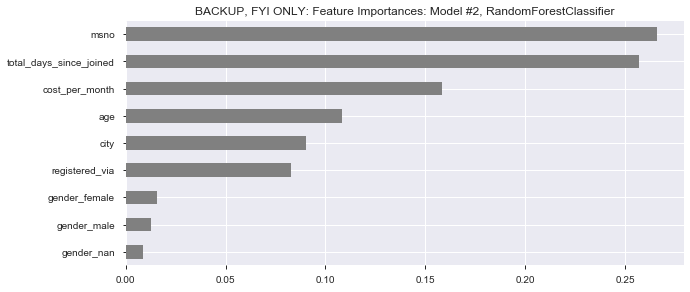

In [300]:
# BACKUP, FYI ONLY: Raw feature importances from model:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

m2_rf_for_feat = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_train).columns
importances = pd.Series(m2_rf_for_feat.feature_importances_, encoded_columns)

# Plot feature importances:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
importances.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Feature Importances: Model #2, RandomForestClassifier')
plt.show()

### Model 3:  Gradient-boosted Trees (Ensemble)

In [303]:
# [?? To do: implement early stopping ??]
# [?? To do: implement grid search or randomizedsearchcv ??]

from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m3_gbt = XGBClassifier(n_estimators=50, max_depth=14, n_jobs=-1, random_state=42)
m3_gbt.fit(X_train_transformed, y_train)

# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = m3_gbt.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('\nModel #3: Gradient-boosted Trees Performance:\n')
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()


Model #3: Gradient-boosted Trees Performance:

TRAINING SET:

Accuracy: 0.973
Recall : 0.598
"Miss Rate" (FNR): 0.402
Log loss (negative): 0.093



In [304]:
# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = m3_gbt.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()


VALIDATION SET:

Accuracy: 0.941
Recall : 0.070
"Miss Rate" (FNR): 0.930
Log loss (negative): 0.232

Confusion matrix, normalized:


,pred_0,pred_1
actual_0,0.937349,0.005622
actual_1,0.053012,0.004016


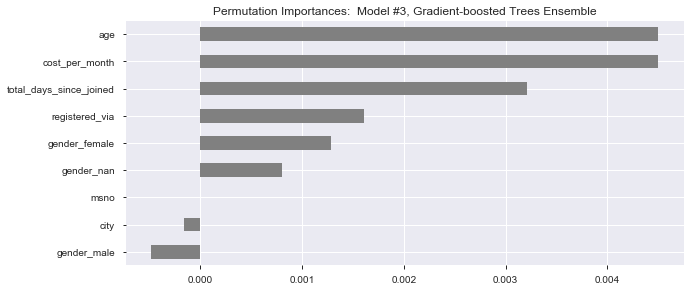

In [305]:
# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_gbt = PermutationImportance(
    m3_gbt, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter_gbt.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_gbt = pd.Series(permuter_gbt.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_gbt.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #3, Gradient-boosted Trees Ensemble')
plt.show()

In [306]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_gbt, 
    top=None, 
    feature_names=feature_names
)

Weight,Feature
0.0045 ± 0.0039,age
0.0045 ± 0.0046,cost_per_month
0.0032 ± 0.0020,total_days_since_joined
0.0016 ± 0.0027,registered_via
0.0013 ± 0.0022,gender_female
0.0008 ± 0.0000,gender_nan
0 ± 0.0000,msno
-0.0002 ± 0.0051,city
-0.0005 ± 0.0008,gender_male


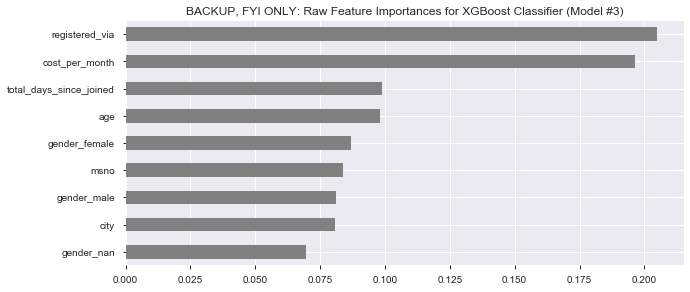

In [307]:
# BACKUP / FYI ONLY:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = transformers.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
feat_importances_gbt = pd.Series(m3_gbt.feature_importances_, encoded_columns)

# Plot on chart, sorted from most to least important:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
feat_importances_gbt.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Raw Feature Importances for XGBoost Classifier (Model #3)')
plt.show()

In [308]:
# To do:  Try setting (class_weight='balanced') in the estimator (e.g., LogisticRegressionCV) and/or consider different 
# class weights, to see if that would result in better predictive models (considering class imbalance in training data).

In [309]:
# Type of problem:  Classification + Regression Predicted Probability
# e.g., Churn:  “Which 5% of my customers will leave my business for a 
# competitor in the next year?” can be rephrased as “How likely is each 
# of my customers to leave my business for a competitor in the next year?”

# Core metric:  
# (1) Recall: maximize
# --> Our model's improvement in recall, as quantified in NT (and equivalent $$) amount!

# (2) False Negative Rate (FNR): minimize:

In [310]:
# e.g., Churn:  “Which 5% of my customers will leave my business for a competitor in the next year?” 
# can be rephrased as “How likely is each of my customers to leave my business for a competitor in the next year?”